# Traning Model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Transfer learning

In [2]:
#Use (InceptionV3) model from keras
pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
#freeze the base model
pre_trained_model.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape : (None, 7, 7, 768)


In [23]:
len(pre_trained_model.layers)

311

In [4]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
#The Final layer with 3 outputs for 3 categories
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
#load features and target numpy
features = np.load('../data/features.npy')
target = np.load('../data/target.npy')

print(features.shape, target.shape)

(4078, 150, 150, 3) (4078, 3)


In [6]:
# Normalize
features = features / 255.

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2)
epochs = 25

In [8]:
model.compile(optimizer='adam',
              loss=tf.losses.categorical_crossentropy,
              metrics=['acc'])

H = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    validation_split=0.12)

Epoch 1/25
90/90 [==============================] - 7s 75ms/step - loss: 0.9514 - acc: 0.9216 - val_loss: 0.3320 - val_acc: 0.9260
Epoch 2/25
90/90 [==============================] - 5s 53ms/step - loss: 0.1461 - acc: 0.9666 - val_loss: 0.1758 - val_acc: 0.9592
Epoch 3/25
90/90 [==============================] - 5s 53ms/step - loss: 0.0609 - acc: 0.9833 - val_loss: 0.2389 - val_acc: 0.9439
Epoch 4/25
90/90 [==============================] - 5s 53ms/step - loss: 0.0393 - acc: 0.9889 - val_loss: 0.1760 - val_acc: 0.9566
Epoch 5/25
90/90 [==============================] - 5s 53ms/step - loss: 0.0275 - acc: 0.9930 - val_loss: 0.1749 - val_acc: 0.9592
Epoch 6/25
90/90 [==============================] - 5s 53ms/step - loss: 0.0088 - acc: 0.9965 - val_loss: 0.1989 - val_acc: 0.9566
Epoch 7/25
90/90 [==============================] - 5s 53ms/step - loss: 0.0284 - acc: 0.9941 - val_loss: 0.2198 - val_acc: 0.9566
Epoch 8/25
90/90 [==============================] - 5s 53ms/step - loss: 0.0277 - a

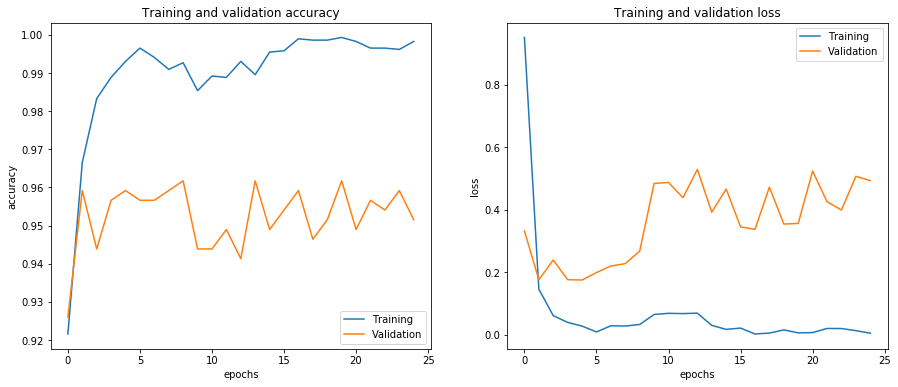

In [9]:
# PLOT LOSS AND ACCURACY
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
model.save('../data/facemask-inceptionV3-model.h5')

## Test the model

In [11]:
model.evaluate(X_test, Y_test)

26/26 [==============================] - 2s 58ms/step - loss: 0.3587 - acc: 0.9608


[0.3587026298046112, 0.9607843160629272]

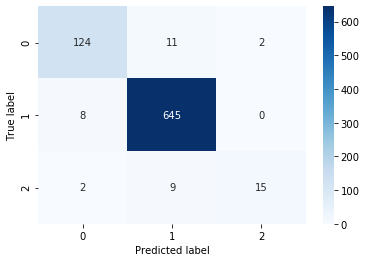

In [12]:
Y_pred = np.argmax(model.predict(X_test), axis=1)

sns.heatmap(confusion_matrix(np.argmax(Y_test, axis=1), Y_pred), annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [13]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(Y_test, axis=1), Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       137
           1       0.97      0.99      0.98       653
           2       0.88      0.58      0.70        26

    accuracy                           0.96       816
   macro avg       0.93      0.82      0.86       816
weighted avg       0.96      0.96      0.96       816



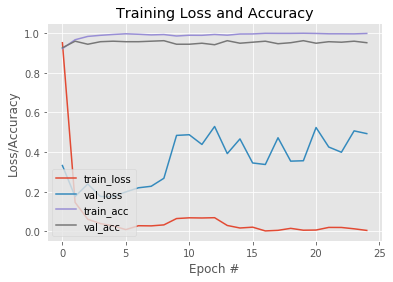

In [14]:
# plot the training loss and accuracy

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Test the best model we have.

In [15]:
model = tf.keras.models.load_model('../data/best-facemask-inceptionV3-model.h5')

In [16]:
model.evaluate(X_test, Y_test)

26/26 [==============================] - 1s 36ms/step - loss: 3.5979e-07 - accuracy: 0.9743


[3.597920681386313e-07, 0.9742646813392639]

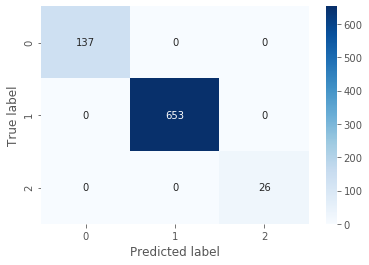

In [17]:
Y_pred = np.argmax(model.predict(X_test), axis=1)

sns.heatmap(confusion_matrix(np.argmax(Y_test, axis=1), Y_pred), annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [18]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(Y_test, axis=1), Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       653
           2       1.00      1.00      1.00        26

    accuracy                           1.00       816
   macro avg       1.00      1.00      1.00       816
weighted avg       1.00      1.00      1.00       816



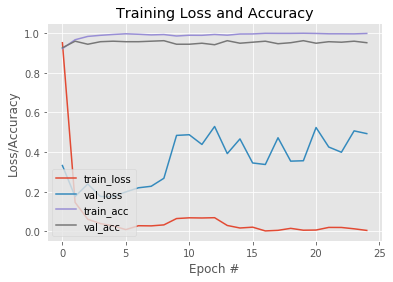

In [19]:
# plot the training loss and accuracy

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")